# Classyfing YouTube videos using tags, number of likes and number of comments


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\miniconda3\envs\youtube-classification\lib\site-pack

In [2]:
from cvs_reader import load_dataframe
from dataframe_creator import create_seperate_columns

# Get dataframes with tags and category_id as columns
ca_csvpath = 'data/CAvideos.csv'
us_csvpath = 'data/USvideos.csv'
gb_csvpath = 'data/GBvideos.csv'

youtube_dfs = [load_dataframe(ca_csvpath, ['tags', 'category_id', 'likes', 'comment_count'])]
youtube_dfs += [load_dataframe(us_csvpath, ['tags', 'category_id', 'likes', 'comment_count'])]
youtube_dfs += [load_dataframe(gb_csvpath, ['tags', 'category_id', 'likes', 'comment_count'])]

# Concat three dataframes into one
youtube_df = pd.concat(youtube_dfs, ignore_index=True)
youtube_df = youtube_df.dropna()
youtube_df.head()

,tags,category_id,likes,comment_count
0,Eminem|Walk|On|Water|Aftermath/Shady/Interscop...,10,787425,125882
1,plush|bad unboxing|unboxing|fan mail|idubbbztv...,23,127794,13030
2,racist superman|rudy|mancuso|king|bach|racist|...,23,146035,8181
3,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,24,132239,17518
4,edsheeran|ed sheeran|acoustic|live|cover|offic...,10,1634130,85067


In [3]:
# Remove 'none' and duplicated values from dataframe
youtube_df = youtube_df[youtube_df['tags']!='[none]']
youtube_df = youtube_df.drop_duplicates(subset='tags')
youtube_df.head()

,tags,category_id,likes,comment_count
0,Eminem|Walk|On|Water|Aftermath/Shady/Interscop...,10,787425,125882
1,plush|bad unboxing|unboxing|fan mail|idubbbztv...,23,127794,13030
2,racist superman|rudy|mancuso|king|bach|racist|...,23,146035,8181
3,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,24,132239,17518
4,edsheeran|ed sheeran|acoustic|live|cover|offic...,10,1634130,85067


In [4]:
# delete categories because of lack of data
to_delete = [2, 15, 19, 29, 30, 43]
for cat in to_delete:
    youtube_df = youtube_df[youtube_df.category_id != cat]
youtube_df.head()

,tags,category_id,likes,comment_count
0,Eminem|Walk|On|Water|Aftermath/Shady/Interscop...,10,787425,125882
1,plush|bad unboxing|unboxing|fan mail|idubbbztv...,23,127794,13030
2,racist superman|rudy|mancuso|king|bach|racist|...,23,146035,8181
3,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,24,132239,17518
4,edsheeran|ed sheeran|acoustic|live|cover|offic...,10,1634130,85067


In [5]:
# For now we only use tags as inputs.
# tags_df = youtube_df.drop(['likes', 'comment_count'], axis=1)
tags_df = youtube_df
tags_df

,tags,category_id,likes,comment_count
0,Eminem|Walk|On|Water|Aftermath/Shady/Interscop...,10,787425,125882
1,plush|bad unboxing|unboxing|fan mail|idubbbztv...,23,127794,13030
2,racist superman|rudy|mancuso|king|bach|racist|...,23,146035,8181
3,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,24,132239,17518
4,edsheeran|ed sheeran|acoustic|live|cover|offic...,10,1634130,85067
5,DramaAlert|Drama|Alert|DramaAlert|keemstar|you...,25,103755,12143
6,Funny Moments|Montage video games|gaming|Vanos...,23,187464,26629
7,SHANtell martin,22,57534,15959
8,logan paul vlog|logan paul|logan|paul|olympics...,24,292837,36391
9,God|Sheldon Cooper|Young Sheldon,22,4135,1484


In [6]:
# Spliting dataframe into several dfs based on category_id
dfs = [x for _, x in tags_df.groupby('category_id')]
for df in dfs:
    print(df.head())

                                                  tags  category_id  likes  \
12   電視劇|大陸電視劇|猎场|职场|商战|爱情|都市|胡歌|陈龙|孙红雷|张嘉译|祖峰|李强|胡...            1    218   
18   Rooster Teeth|RT|animation|television|filmmaki...            1  19541   
19   sharry mann|sharry mann new song|sharry mann c...            1  33966   
45   DNC Chairwoman Donna Brazile|Hacks|The Inside ...            1   4903   
103  baby driver|edgar wright|everything wrong with...            1  58967   

     comment_count  
12             186  
18             495  
19             882  
45            1289  
103           7915  
                                                 tags  category_id    likes  \
0   Eminem|Walk|On|Water|Aftermath/Shady/Interscop...           10   787425   
4   edsheeran|ed sheeran|acoustic|live|cover|offic...           10  1634130   
10  21 savage|bank account|21 savage bank account|...           10   263596   
13  punjabi songs|punjabi bhangra|punjabi music|pu...           10   127477   
29  Telefo

In [7]:
from sklearn.utils import resample

resampled_dfs = []
for df in dfs:
    if df.shape[0] < 2000:
        resampled_dfs += [resample(df, n_samples=2000)]
    else:
        resampled_dfs += [df.sample(n=2000)]

    
# Resampling datas to make them balanced
tags_df = pd.concat(resampled_dfs, axis=0, ignore_index=True)
tags_df.head()

,tags,category_id,likes,comment_count
0,恐怖|惊悚|悬疑|美女|爱情|鬼故事|灵异|几分钟看电影|几分钟说电影|影视解说|电影解说,1,1434,217
1,鬼故事|灵异|悬疑片|恐怖片|惊悚片|报应|奸商|几分钟看电影|几分钟说电影|电影解说|影视解说,1,871,185
2,animation|art|katzun|storytime|animated|tweeni...,1,20865,5883
3,印度|美国,1,164,18
4,Rooster Teeth|RT|animation|television|filmmaki...,1,24349,3972


In [8]:
new_categories_dict = {1:1, 10:2, 17:3, 20:4, 22:5, 23:6, 24:7, 25:8, 26:9, 27:10, 28:11}
reversed_new_categories_dict = {value:key for key, value in new_categories_dict.items()}
categories = tags_df['category_id']
tags_df['category_id'] = categories.map(new_categories_dict)
tags_df.head()

,tags,category_id,likes,comment_count
0,恐怖|惊悚|悬疑|美女|爱情|鬼故事|灵异|几分钟看电影|几分钟说电影|影视解说|电影解说,1,1434,217
1,鬼故事|灵异|悬疑片|恐怖片|惊悚片|报应|奸商|几分钟看电影|几分钟说电影|电影解说|影视解说,1,871,185
2,animation|art|katzun|storytime|animated|tweeni...,1,20865,5883
3,印度|美国,1,164,18
4,Rooster Teeth|RT|animation|television|filmmaki...,1,24349,3972


In [9]:
from vocab_handler import get_tags_frequency, get_tags_vocab, get_tags_vocab_as_dict


tag_frequency = get_tags_frequency(tags_df['tags'])
lists = sorted(tag_frequency.items()) # sorted by key, return a list of tuples

lists[:10]

[('', 6),
 (" 'Gandarrappido: The Revenger Squad ", 0),
 (' 080118 💖', 0),
 (' 100% Will Get Satisfied', 0),
 (' 101217 💚', 0),
 (' 140118 💖', 1),
 (' 150118 💖', 2),
 (' 171217 💚', 2),
 (' 2018', 1),
 (' 210118 💖', 1)]

In [10]:
pruned_vocab = get_tags_vocab(tag_frequency, 50)
vocab_di = get_tags_vocab_as_dict(pruned_vocab)

In [11]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()


tags_df[['likes', 'comment_count']] = scaler.fit_transform(tags_df[['likes', 'comment_count']])


In [12]:
max_of_tags = 96

tags_df = create_seperate_columns(tags_df, max_of_tags, 'tags')
tags_df

,category_id,likes,comment_count,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,...,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95
0,1,-0.279624,-0.213201,恐怖,惊悚,悬疑,美女,爱情,鬼故事,灵异,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
1,1,-0.287429,-0.215781,鬼故事,灵异,悬疑片,恐怖片,惊悚片,报应,奸商,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
2,1,-0.010267,0.243702,animation,art,katzun,storytime,animated,tweening,hand drawn,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
3,1,-0.297229,-0.229248,印度,美国,notags,notags,notags,notags,notags,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
4,1,0.038029,0.089600,Rooster Teeth,RT,animation,television,filmmaking,games,video games,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
5,1,-0.256876,-0.197315,Ready Player One Trailer,Ready Player One Movie Trailer,Ready Player One Trailer 2018,Official Trailer,Trailer,Trailers,Movie Trailer,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
6,1,-0.298865,-0.228603,Meryl,Streep,kramer,vs,dustin,hoffman,clou,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
7,1,2.362564,0.820032,Black Panther,HISHE,Marvel,Infinity War,How It Should Have Ended,parody,comedy,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
8,1,-0.289494,-0.223120,Cinema,Trailer,Official,Movie,Film,City of Lies,Johnny Depp,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
9,1,0.053971,-0.122159,original color,Uncle Drew,LIONSGATE,Kyrie Irving,Lil Rel Howery,Shaquille O’Neal,Reggie Miller,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags


In [13]:
def one_hot(tags_df, non_one_hot_columns):
    future_df = []
    col_row_dict = {}
    
    for i in range(0, 22000):
        for col in tags_df.columns:
            if col in non_one_hot_columns:
                col_row_dict[col] = tags_df[col][i]
            elif tags_df[col][i] in pruned_vocab:
                    col_row_dict[tags_df[col][i]] = 1.0
        future_df.append(col_row_dict)
        col_row_dict = {}
        
    return future_df

In [14]:
tags_df[tags_df.duplicated()]

,category_id,likes,comment_count,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,...,tag_86,tag_87,tag_88,tag_89,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95
28,1,1.414815,1.463616,jaiden,animations,jaidenanimation,jaidenanimations,fitness,jaidenanimations fitness,jaidenanimations health,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
60,1,-0.287429,-0.215781,鬼故事,灵异,悬疑片,恐怖片,惊悚片,报应,奸商,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
95,1,-0.293958,-0.216427,bạn muốn hẹn hò,ban muon hen ho,ban muon hen ho tap 348,ban muon hen ho 348,ban muon hen ho 348,bmhh tap 348,bmhh 348,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
105,1,-0.289494,-0.223120,Cinema,Trailer,Official,Movie,Film,City of Lies,Johnny Depp,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
107,1,-0.205780,-0.145706,its alex clark,itsalexclark,alex clark,itsalexclark youtube,youtube itsalexclark,itsalexclark channel,animation,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
137,1,-0.262920,-0.158366,idoles saison 4 épisode 2,Even Prod,idoles saison 4,Idoles,idoles episode 2,idoles 2,grand laye,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
147,1,0.074903,0.014364,screen junkies,screenjunkies,honest trailers,honest trailer,the rock,kevin hart,jack black,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
159,1,0.496385,0.380386,ChristopherRobin DomesticTrailer1 NoGreenband ...,christopher robin,winnie the pooh,tigger,eeyore,piglet,owl,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
173,1,-0.212462,-0.168123,Reddit,Video,Marshal,Does,Stuff,Marshal Does Stuff,Best of,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
178,1,0.086395,-0.027166,happy death day,groundhog day,horror,cinemasins,cinema sins,everything wrong with,eww,...,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags


In [15]:
one_hot_list = one_hot(tags_df, ['category_id', 'comment_count', 'likes'])
tags_df = pd.DataFrame(one_hot_list)
tags_df.fillna(0.0, inplace = True)
tags_df

,category_id,likes,comment_count,几分钟看电影,电影解说,animation,art,animated,Rooster Teeth,RT,...,TED-Ed,TED Ed,tom scott,tomscott,chris conte,the infographics show,dr nozman,nozman,docteur nozman,secureteam10
0,1,-0.279624,-0.213201,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,-0.287429,-0.215781,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,-0.010267,0.243702,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,-0.297229,-0.229248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.038029,0.089600,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,-0.256876,-0.197315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,-0.298865,-0.228603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,2.362564,0.820032,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1,-0.289494,-0.223120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1,0.053971,-0.122159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# data = [{'Geeks': 1.0, 'For': 1.0, 'geeks': 1.0}, 
#         {'Geeks':1.0, 'For': 1.0, 'For':1.0},{'test':1.0, 'hi': 1, 'For':1} ]  
    
# # Creates DataFrame.  
# df = pd.DataFrame(data)
# df.fillna(0, inplace=True)
    
# # Print the data  
# df 


In [18]:
from input_generator import generate_dataset


# Create train,validation and test examples from tags and labels dataframe

(train_ds, train_lb), (val_ds, val_lb), (test_ds, test_lb) = generate_dataset(tags_df, 'category_id')

In [27]:
hidden = 128
model = tf.keras.Sequential([
    layers.Dense(hidden,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2*hidden,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(hidden*2,activation='relu'),
    layers.Dense(hidden/2,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(12, activation='softmax')])

nadam = keras.optimizers.Nadam(lr=0.00001)

model.compile(optimizer=nadam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds.values, train_lb.values,
                    batch_size=32,
                    epochs=250,
                    validation_data=(val_ds.values, val_lb.values))


Train on 13200 samples, validate on 4400 samples
Epoch 1/250
13200/13200 [==============================] - 3s 221us/sample - loss: 2.4897 - acc: 0.0854 - val_loss: 2.4802 - val_acc: 0.0950
Epoch 2/250
13200/13200 [==============================] - 2s 188us/sample - loss: 2.4796 - acc: 0.0915 - val_loss: 2.4727 - val_acc: 0.1134
Epoch 3/250
13200/13200 [==============================] - 3s 194us/sample - loss: 2.4717 - acc: 0.1009 - val_loss: 2.4649 - val_acc: 0.1241
Epoch 4/250
13200/13200 [==============================] - 3s 194us/sample - loss: 2.4655 - acc: 0.1027 - val_loss: 2.4566 - val_acc: 0.1466
Epoch 5/250
13200/13200 [==============================] - 3s 196us/sample - loss: 2.4550 - acc: 0.1155 - val_loss: 2.4469 - val_acc: 0.1570
Epoch 6/250
13200/13200 [==============================] - 3s 204us/sample - loss: 2.4491 - acc: 0.1164 - val_loss: 2.4366 - val_acc: 0.1659
Epoch 7/250
13200/13200 [==============================] - 3s 203us/sample - loss: 2.4389 - acc: 0.1220 -

13200/13200 [==============================] - 3s 210us/sample - loss: 1.5032 - acc: 0.5253 - val_loss: 1.3586 - val_acc: 0.5761
Epoch 59/250
13200/13200 [==============================] - 3s 208us/sample - loss: 1.4899 - acc: 0.5229 - val_loss: 1.3521 - val_acc: 0.5770
Epoch 60/250
13200/13200 [==============================] - 3s 205us/sample - loss: 1.4840 - acc: 0.5302 - val_loss: 1.3463 - val_acc: 0.5800
Epoch 61/250
13200/13200 [==============================] - 3s 206us/sample - loss: 1.4818 - acc: 0.5314 - val_loss: 1.3409 - val_acc: 0.5809
Epoch 62/250
13200/13200 [==============================] - 3s 210us/sample - loss: 1.4686 - acc: 0.5324 - val_loss: 1.3345 - val_acc: 0.5830
Epoch 63/250
13200/13200 [==============================] - 3s 211us/sample - loss: 1.4637 - acc: 0.5385 - val_loss: 1.3299 - val_acc: 0.5845
Epoch 64/250
13200/13200 [==============================] - 3s 211us/sample - loss: 1.4442 - acc: 0.5361 - val_loss: 1.3247 - val_acc: 0.5866
Epoch 65/250
13200/

13200/13200 [==============================] - 3s 224us/sample - loss: 1.2179 - acc: 0.6081 - val_loss: 1.1802 - val_acc: 0.6275
Epoch 116/250
13200/13200 [==============================] - 3s 232us/sample - loss: 1.2212 - acc: 0.6059 - val_loss: 1.1787 - val_acc: 0.6270
Epoch 117/250
13200/13200 [==============================] - 3s 214us/sample - loss: 1.2262 - acc: 0.6054 - val_loss: 1.1769 - val_acc: 0.6284
Epoch 118/250
13200/13200 [==============================] - 3s 220us/sample - loss: 1.2256 - acc: 0.6093 - val_loss: 1.1750 - val_acc: 0.6286
Epoch 119/250
13200/13200 [==============================] - 3s 209us/sample - loss: 1.2156 - acc: 0.6122 - val_loss: 1.1743 - val_acc: 0.6191
Epoch 120/250
13200/13200 [==============================] - 3s 207us/sample - loss: 1.2146 - acc: 0.6125 - val_loss: 1.1738 - val_acc: 0.6264
Epoch 121/250
13200/13200 [==============================] - 3s 211us/sample - loss: 1.2041 - acc: 0.6142 - val_loss: 1.1721 - val_acc: 0.6264
Epoch 122/250

13200/13200 [==============================] - 3s 209us/sample - loss: 1.1070 - acc: 0.6439 - val_loss: 1.1250 - val_acc: 0.6430
Epoch 173/250
13200/13200 [==============================] - 3s 213us/sample - loss: 1.1108 - acc: 0.6417 - val_loss: 1.1240 - val_acc: 0.6425
Epoch 174/250
13200/13200 [==============================] - 3s 212us/sample - loss: 1.0965 - acc: 0.6432 - val_loss: 1.1239 - val_acc: 0.6441
Epoch 175/250
13200/13200 [==============================] - 3s 226us/sample - loss: 1.1009 - acc: 0.6464 - val_loss: 1.1235 - val_acc: 0.6418
Epoch 176/250
13200/13200 [==============================] - 3s 222us/sample - loss: 1.0926 - acc: 0.6459 - val_loss: 1.1234 - val_acc: 0.6423
Epoch 177/250
13200/13200 [==============================] - 3s 219us/sample - loss: 1.1005 - acc: 0.6486 - val_loss: 1.1222 - val_acc: 0.6427
Epoch 178/250
13200/13200 [==============================] - 3s 220us/sample - loss: 1.0940 - acc: 0.6458 - val_loss: 1.1212 - val_acc: 0.6441
Epoch 179/250

13200/13200 [==============================] - 3s 199us/sample - loss: 1.0289 - acc: 0.6658 - val_loss: 1.0990 - val_acc: 0.6516
Epoch 230/250
13200/13200 [==============================] - 3s 195us/sample - loss: 1.0252 - acc: 0.6635 - val_loss: 1.0981 - val_acc: 0.6518
Epoch 231/250
13200/13200 [==============================] - 3s 191us/sample - loss: 1.0169 - acc: 0.6657 - val_loss: 1.0986 - val_acc: 0.6527
Epoch 232/250
13200/13200 [==============================] - 3s 197us/sample - loss: 1.0241 - acc: 0.6672 - val_loss: 1.0984 - val_acc: 0.6523
Epoch 233/250
13200/13200 [==============================] - 3s 195us/sample - loss: 1.0221 - acc: 0.6644 - val_loss: 1.0974 - val_acc: 0.6530
Epoch 234/250
13200/13200 [==============================] - 3s 193us/sample - loss: 1.0192 - acc: 0.6683 - val_loss: 1.0970 - val_acc: 0.6520
Epoch 235/250
13200/13200 [==============================] - 3s 191us/sample - loss: 1.0100 - acc: 0.6650 - val_loss: 1.0973 - val_acc: 0.6525
Epoch 236/250

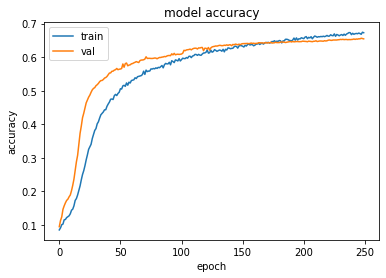

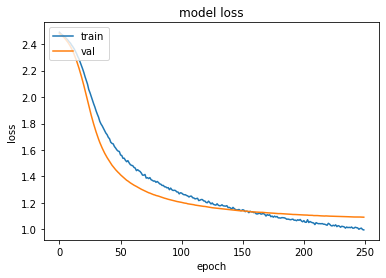

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
results = model.evaluate(test_ds, test_lb)

print(results)

4400/4400 [==============================] - 0s 43us/sample - loss: 1.0980 - acc: 0.6525
[1.0980451878634365, 0.6525]


In [30]:
from tag_handler import get_category_title_dict

predictions = model.predict(test_ds)
cat_tit_dict = get_category_title_dict('data/json/CA_category_id.json')
cat_tit_dict.update(get_category_title_dict('data/json/US_category_id.json'))
cat_tit_dict.update(get_category_title_dict('data/json/GB_category_id.json'))

In [31]:
from sklearn.metrics import classification_report
print(classification_report(test_lb, np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           1       0.78      0.59      0.67       386
           2       0.55      0.82      0.66       400
           3       0.90      0.80      0.85       394
           4       0.66      0.70      0.68       374
           5       0.29      0.50      0.37       419
           6       0.78      0.61      0.68       428
           7       0.49      0.46      0.47       409
           8       0.78      0.65      0.71       417
           9       0.81      0.65      0.72       396
          10       0.83      0.76      0.79       385
          11       0.82      0.66      0.73       392

    accuracy                           0.65      4400
   macro avg       0.70      0.65      0.67      4400
weighted avg       0.70      0.65      0.66      4400



In [24]:
def one_hot_to_index(one_hot):
    i_tags = []
    for i, b in enumerate(one_hot):
        if b == 1.0:
            i_tags.append(i)      
    return i_tags

def index_to_tag(i_tags):
    w_tags = []
    reversed_vocab_dict = {i: vo for vo, i in vocab_di.items()}
    for index in i_tags:
        w_tags.append(reversed_vocab_dict[index])
    return w_tags


In [34]:
for i in range(30, 40):
    y_pred = reversed_new_categories_dict[np.argmax(predictions[i])]
    label = reversed_new_categories_dict[test_lb.values[i]]
    print('""""""""""""""""""""""""""""""""""""""""""""""""')
    print('predict:{}'.format(cat_tit_dict[str(y_pred)]))
    print('true label:{}'.format(cat_tit_dict[str(label)]))

""""""""""""""""""""""""""""""""""""""""""""""""
predict:Music
true label:Music
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Science & Technology
true label:Science & Technology
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Film & Animation
true label:Film & Animation
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Music
true label:Music
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Gaming
true label:Gaming
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Gaming
true label:Education
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Music
true label:Music
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Gaming
true label:Gaming
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Education
true label:Education
""""""""""""""""""""""""""""""""""""""""""""""""
predict:Howto & Style
true label:Gaming
